In [1]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary

from matplotlib import pyplot as plt

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using device: %s" % device)

using device: cuda


In [2]:
# prepare data

from appleorange import AppleOrangeDataset
from torch.utils.data import DataLoader

IMAGE_SIZE = 256

transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.33)),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

apple_train_dir = r"E:\datasets\apple-orange\apples_train"
orange_train_dir = r"E:\datasets\apple-orange\oranges_train"

apple_test_dir = r"E:\datasets\apple-orange\apples_test"
orange_test_dir = r"E:\datasets\apple-orange\oranges_test"

train_ds = AppleOrangeDataset(apple_train_dir, orange_train_dir, transforms=transform, device=device)
test_ds = AppleOrangeDataset(apple_test_dir, orange_test_dir, transforms=transform, device=device)

train_dl = DataLoader(train_ds, batch_size=6, shuffle=True, collate_fn=train_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

print("train data: %d, test data: %d" % (len(train_ds), len(test_ds)))


train data: 3067, test data: 1021


In [3]:
# prepare network
def weight_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
    else:
        pass # default

class ResBlock(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, xs):
        return self.block(xs) + xs

class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super().__init__()
        out_features = 64
        channels = 3

        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, kernel_size=7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU()
        ]


        # Downsampling
        in_features = out_features
        for _ in range(2):
            out_features *= 2
            layers += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU()
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_blocks):
            layers.append(ResBlock(out_features))
        
        # Upsampling
        for _ in range(2):
            out_features //= 2
            layers += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU()
            ]
            in_features = out_features
        
        # Output lay
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(out_features, channels, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*layers)
        self.apply(weight_init_normal)

    def forward(self, xs):
        return self.model(xs)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE
        def discriminator_block(in_channels, out_channels, normalize=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2))

            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weight_init_normal)
    
    def forward(self, xs):
        return self.model(xs)

@torch.no_grad()
def generate_sample(G_AB, G_BA, dl):
    real_a, real_b = next(iter(dl))
    G_AB.eval()
    G_BA.eval()

    fake_b = G_AB(real_a)
    fake_a = G_BA(real_b)

    real_a = make_grid(real_a, nrows=5, normalize=True)
    real_b = make_grid(real_b, nrows=5, normalize=True)
    fake_a = make_grid(fake_a, nrows=5, normalize=True)
    fake_b = make_grid(fake_b, nrows=5, normalize=True)

    image_grid = torch.cat([real_a, fake_b, real_b, fake_a], axis=1)
    plt.imshow(image_grid.detach().cpu().permute(1,2,0).numpy())

G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

In [4]:
# trainning functions
lambda_cycle = 10.0
lambda_id = 5.0

identity_lossfn = nn.L1Loss()
gan_lossfn = nn.MSELoss()
cycle_lossfn = nn.L1Loss()

def train_generator_step(G_AB, G_BA, real_a, real_b, optimizer):
    optimizer.zero_grad()
    loss_id_a = identity_lossfn(G_BA(real_a), real_a)
    loss_id_b = identity_lossfn(G_AB(real_b), real_b)
    loss_id = (loss_id_a + loss_id_b) / 2

    fake_b = G_AB(real_a)
    fake_a = G_BA(real_b)
    loss_gan_b = gan_lossfn(D_B(fake_b), torch.ones((len(real_a), 1, 16, 16)).to(device))
    loss_gan_a = gan_lossfn(D_A(fake_a), torch.ones((len(real_b), 1, 16, 16)).to(device))
    loss_gan = (loss_gan_a + loss_gan_b) / 2

    recov_a = G_BA(fake_b)
    recov_b = G_AB(fake_a)
    loss_cycle_a = cycle_lossfn(recov_a, real_a)
    loss_cycle_b = cycle_lossfn(recov_b, real_b)
    loss_cycle = (loss_cycle_a + loss_cycle_b) / 2

    loss = loss_gan + lambda_cycle * loss_cycle + lambda_id * loss_id
    loss.backward()
    optimizer.step()

    return loss, loss_id, loss_gan, loss_cycle, fake_a, fake_b

def train_discrimitor_step(D, real, fake, optimizer):
    optimizer.zero_grad()
    loss_real = gan_lossfn(D(real), torch.ones((len(real), 1, 16, 16)).to(device))
    loss_fake = gan_lossfn(D(fake), torch.zeros(len(fake), 1, 16, 16).to(device))
    loss = (loss_real + loss_fake) / 2
    loss.backward()
    optimizer.step()

    return loss


In [6]:
# trainning process
import time
optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=1e-3)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=1e-3)
optimizer_D_B = optim.Adam(D_B.parameters(), lr=1e-3)

for epoch in range(10):
    start = time.time()
    for real_a, real_b in train_dl:
        loss_g, loss_id, loss_gan, loss_cycle, fake_a, fake_b = \
            train_generator_step(G_AB, G_BA, real_a, real_b, optimizer_G)
        loss_d_a = train_discrimitor_step(D_A, real_a, fake_a.detach(), optimizer_D_A)
        loss_d_b = train_discrimitor_step(D_B, real_b, fake_b.detach(), optimizer_D_B)
        loss_d = (loss_d_a + loss_d_b) / 2
    end = time.time()
    print("epoch: %d, consume %ds, loss_g=%.2f, loss_d=%.2f" % (epoch, end-start, loss_g, loss_d))



epoch: 0, consume 502s, loss_g=2.55, loss_d=0.22
epoch: 1, consume 475s, loss_g=1.98, loss_d=0.15
epoch: 2, consume 474s, loss_g=2.13, loss_d=0.23
epoch: 3, consume 474s, loss_g=1.79, loss_d=0.17
epoch: 4, consume 474s, loss_g=1.29, loss_d=0.27
epoch: 5, consume 474s, loss_g=1.52, loss_d=0.14
epoch: 6, consume 474s, loss_g=1.64, loss_d=0.26
epoch: 7, consume 474s, loss_g=1.34, loss_d=0.16
epoch: 8, consume 474s, loss_g=1.28, loss_d=0.22
epoch: 9, consume 474s, loss_g=1.61, loss_d=0.20


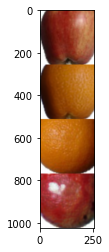

In [7]:
generate_sample(G_AB, G_BA, test_dl)